## Loading sakila database into duckdb

In [88]:
import duckdb
from pathlib import Path

In [89]:
duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

# open and close the file securely
with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()

description.index = description.index + 1

description.head(3)

,database,schema,name,column_names,column_types,temporary
1,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
2,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
3,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


In [90]:
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM {name};").df()

dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

In [91]:
table_names = ["film", "film_actor", "actor", "film_category", "category", "inventory", "rental", "customer", "payment"]

for table_name in table_names:
    duckdb.register(table_name, dfs[table_name])

In [92]:
# movies longer than 3 hours
long_movies = duckdb.sql("""
            SELECT
                title,
                length || ' minutes' AS length
            FROM
                film
            WHERE
                length > 180;            
""").df()
long_movies.index = long_movies.index + 1

long_movies.head(4)

,title,length
1,ANALYZE HOOSIERS,181 minutes
2,BAKED CLEOPATRA,182 minutes
3,CATCH AMISTAD,183 minutes
4,CHICAGO NORTH,185 minutes


In [93]:
# movies which have the word "love" in the title
# searching only for love by it self, not inside a word
love_in_title = duckdb.sql("""
            SELECT
                title,
                rating,
                length || ' minutes' AS length,
                description
            FROM
                film
            WHERE
                title LIKE 'LOVE %' OR
                title LIKE '% LOVE' OR
                title LIKE '% LOVE %';                             
""").df()
# TODO: Ask if/how regexp work with python to do 'regexp_matches (title, '\bLOVE\b')'

love_in_title.index = love_in_title.index + 1

love_in_title

,title,rating,length,description
1,GRAFFITI LOVE,PG,117 minutes,A Unbelieveable Epistle of a Sumo Wrestler And...
2,IDAHO LOVE,PG-13,172 minutes,A Fast-Paced Drama of a Student And a Crocodil...
3,INDIAN LOVE,NC-17,135 minutes,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175 minutes,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181 minutes,A Brilliant Panorama of a Hunter And a Explore...


In [94]:
# calculating statistics on the length of all movies
length_statistics = duckdb.sql("""
            SELECT
                MIN(length) AS hortest_movie_min,
                ROUND(AVG(length)) AS average_movie_min,
                MEDIAN (length) AS median_length_min,
                MAX(length) AS longest_movie_min
            FROM
                film;
""").df()
length_statistics.index = length_statistics.index + 1

length_statistics

,hortest_movie_min,average_movie_min,median_length_min,longest_movie_min
1,46,115.0,114.0,185


In [95]:
# most expensive movies to rent per day
# several movies are as expensive as these once
most_expensive_movies = duckdb.sql("""
            SELECT
                title,
                rental_rate,
                rental_duration,
                ROUND(rental_rate / rental_duration, 2) AS rate_per_day
            FROM
                film
            ORDER BY
                rate_per_day DESC
            LIMIT
                10;
""").df()
most_expensive_movies.index = most_expensive_movies.index + 1

most_expensive_movies

,title,rental_rate,rental_duration,rate_per_day
1,AMERICAN CIRCUS,4.99,3,1.66
2,BACKLASH UNDEFEATED,4.99,3,1.66
3,BILKO ANONYMOUS,4.99,3,1.66
4,BEAST HUNCHBACK,4.99,3,1.66
5,CARIBBEAN LIBERTY,4.99,3,1.66
6,AUTUMN CROW,4.99,3,1.66
7,CASPER DRAGONFLY,4.99,3,1.66
8,ACE GOLDFINGER,4.99,3,1.66
9,BEHAVIOR RUNAWAY,4.99,3,1.66
10,CASUALTIES ENCINO,4.99,3,1.66


In [96]:
# actors who played in most movies
most_movie_actors = duckdb.sql("""
            SELECT 
                a.first_name || ' ' || a.last_name AS actor_name,
                COUNT(DISTINCT fa.film_id) AS number_of_films
            FROM actor a
                LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
            GROUP BY actor_name
            ORDER BY number_of_films DESC
            LIMIT 10;
            """).df()
most_movie_actors.index = most_movie_actors.index + 1

most_movie_actors

,actor_name,number_of_films
1,SUSAN DAVIS,54
2,GINA DEGENERES,42
3,WALTER TORN,41
4,MARY KEITEL,40
5,MATTHEW CARREY,39
6,SANDRA KILMER,37
7,SCARLETT DAMON,36
8,VAL BOLGER,35
9,GROUCHO DUNST,35
10,ANGELA WITHERSPOON,35


In [99]:
top_paying_customers = duckdb.sql("""
            SELECT
                DISTINCT c.first_name || ' ' || c.last_name AS customer_name,
                ROUND(SUM(p.amount)) AS amount
            FROM
                customer c
                INNER JOIN payment p ON c.customer_id = p.customer_id
            GROUP BY customer_name
            ORDER BY amount DESC
            LIMIT 5;
""").df()

<Axes: title={'center': 'Top 5 paying customers'}, xlabel='customer', ylabel='total payments'>

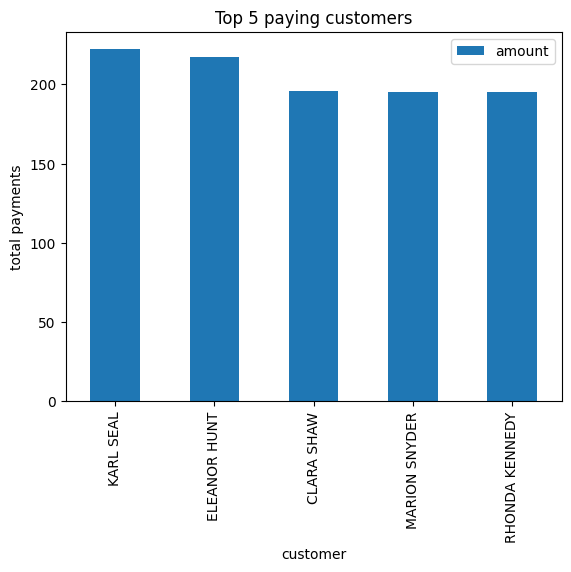

In [106]:
top_paying_customers.plot(kind="bar", x="customer_name", y="amount", xlabel="customer", ylabel="total payments", title="Top 5 paying customers")

In [107]:
category_revenue = duckdb.sql("""
            SELECT
                DISTINCT c.name,
                SUM(p.amount) AS amount
            FROM category c
                LEFT JOIN film_category fc ON c.category_id = fc.category_id
                LEFT JOIN inventory i ON fc.film_id = i.film_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN payment p ON p.rental_id = r.rental_id
            GROUP BY c.name
            ORDER BY c.name;
""").df()

<Axes: title={'center': 'revenue per category'}, xlabel='category', ylabel='revenue'>

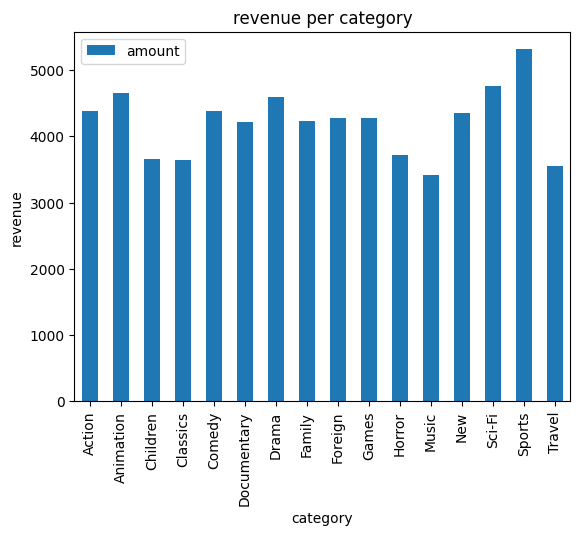

In [112]:
category_revenue.plot(kind="bar", x="name", y="amount", xlabel="category", ylabel="revenue", title="revenue per category")